In [1]:
# !pip install --upgrade-strategy=only-if-needed tensorflow~=1.6.0rc0
# !pip install -U gensim~=3.2.0

In [15]:
import gensim
import gzip
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from gensim.test.utils import common_texts, get_tmpfile
from model_tool import ToxModel
execfile("./FairAI.py")

HELLO from model_tool


Using TensorFlow backend.


In [2]:
local_dir_name = '../data'
WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")

In [3]:
%%time
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client = load_word2vec_format(f, max_num_words=2000000)
embeddings = client

Loading word embeddings from ../data/embeddings/GoogleNews-vectors-negative300.bin.gz
vector_size =  300
Loading 2000000 embeddings
('duplicate words detected, shrinking matrix size from %i to %i', 3000000, 2000000)
('loaded %s matrix', (2000000, 300))
CPU times: user 46.3 s, sys: 1.68 s, total: 48 s
Wall time: 48.2 s


In [248]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)
client = embeddings

## Are there harmful anaolgies with repsect to negative sentiment?

In [4]:
A = "asian"
B = "american"
C = "smart"
NUM_ANALOGIES = 5

in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, -in_arr[0, 0, :] + in_arr[0, 1, :] + in_arr[0, 2, :],
          NUM_ANALOGIES)

5 closest neighbors to A-B+C:
smart : score=0.668151
intelligent : score=0.454270
dumb : score=0.442581
smarter : score=0.412079
american : score=0.410000


In [5]:
analogies = load_analogies(ANALOGIES_FILE)
print "\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[-20:])

loaded 19544 analogies
write is to writes as increase is to increases
write is to writes as listen is to listens
write is to writes as play is to plays
write is to writes as predict is to predicts
write is to writes as provide is to provides
write is to writes as say is to says
write is to writes as scream is to screams
write is to writes as search is to searches
write is to writes as see is to sees
write is to writes as shuffle is to shuffles
write is to writes as sing is to sings
write is to writes as sit is to sits
write is to writes as slow is to slows
write is to writes as speak is to speaks
write is to writes as swim is to swims
write is to writes as talk is to talks
write is to writes as think is to thinks
write is to writes as vanish is to vanishes
write is to writes as walk is to walks
write is to writes as work is to works


In [6]:
embed, indices, words = load_vectors(client, analogies)

embed_dim = len(embed[0].flatten())
print "word embedding dimension: %d" % embed_dim

found 905 unique words
words not filtered out: 905
word embedding dimension: 300


In [70]:
words_in_embeddings = []
for i,j in enumerate(pos_words+neg_words):
    if j.lower() in embeddings:
        words_in_embeddings.append(j)

In [42]:
pos_words = load_lexicon("../data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("../data/opinion_lexicon/negative-words.txt")
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
train_vectors, test_vectors, train_targets, test_targets = train_test_split(vectors, targets, test_size=0.1, random_state=0)

In [43]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors,train_targets)
clf.score(test_vectors,test_targets)


0.9444444444444444

<BarContainer object of 100 artists>

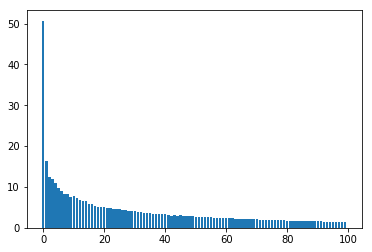

In [35]:
%matplotlib inline

import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
            
good_vectors=[]
bad_vectors = []
# good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
# bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
# good = ['amazing']
# bad = ['horrible']
choices = np.random.choice(len(good),20)
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.dot(X.T,X)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

## create sentiment subspace via our method

<BarContainer object of 100 artists>

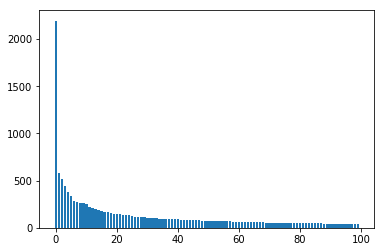

In [44]:
m=np.dot(pos_vectors.T,pos_vectors)
evals, evecs = np.linalg.eig(m)
vec_pos = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(100),evals[:100])

In [45]:
neg_vectors=neg_vectors[np.random.choice(len(pos_vectors),len(pos_vectors))]

<BarContainer object of 100 artists>

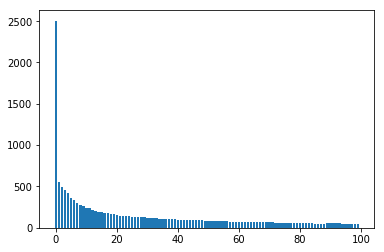

In [46]:
m=np.dot(neg_vectors.T,neg_vectors)
evals, evecs = np.linalg.eig(m)
vec_neg = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(100),evals[:100])

In [57]:
##get direcitonal sentiment vector
# vec=vec_pos-vec_neg
vec=(vec_neg-vec_pos)*-1

In [58]:
WORD = "amazing"
word_vec = _np_normalize(client.word_vec(WORD))
print vec.dot(word_vec.T)

0.28670278


## how does the sign of projection correlate with positive/negative labels

In [59]:
count = 0 
for i,j in zip(vectors,(targets*2-1)*-1):
    if int(np.sign(i.dot(vec))) == j:
        count+=1
print count/float(len(targets))

0.918717256707


In [60]:
MODEL_DIR = '../models/'
debias_model_name = 'wiki_debias_cnn_v3_{}'.format(100)
debias_model = ToxModel(debias_model_name,model_dir=MODEL_DIR)

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 4
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: wiki_debias_cnn_v3_100
max_sequence_length: 250
stop_early: True
embedding_trainable: False



In [75]:
count = 0 
threshold = .5
for  index, (i,j) in enumerate(zip(vectors,(targets*2-1)*-1)):
    if (int(np.sign(i.dot(vec)))+1)/2 == (debias_model.predict([words_in_embeddings[index]])>=threshold):
        count+=1
print count/float(len(targets))

0.657088426734


## define set of identity terms

In [288]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
#     'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
#     'Diasporic',
    'Sikh',
#     'Juche',
    'Jewish',
#     'Bahai',
#     'Jains',
#     'Shinto',
#     'Pagan'
]
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

In [289]:
words = filter(lambda x: x.lower() in embeddings,religions)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: _np_normalize(embeddings[w.lower()]).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

         word  sentiment_score
0     Zionist        -0.129182
5     Atheist        -0.101050
8        Sikh        -0.054650
6       Hindu        -0.023284
4  Protestant         0.003784
3     Islamic         0.042551
9      Jewish         0.065479
1    Catholic         0.089540
7    Buddhist         0.120388
2   Christian         0.178152


Let's now look at the words with the largest *negative* projection onto the sentiment dimension.

In [290]:
words = set()
for a in analogies:
  words.update(a)

df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: _np_normalize(client.word_vec(w.lower())).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df.head(10)


              word  sentiment_score
83       illogical        -0.250451
217     irrational        -0.250015
428     uninformed        -0.246706
508      unethical        -0.240276
743      dishonest        -0.239267
579  irresponsible        -0.227616
60     distasteful        -0.205088
455   unreasonable        -0.202036
97         screams        -0.193080
505            hid        -0.191742


Let's now look at the words with the largest *positive* projection onto the sentiment dimension.

In [291]:
df.sort_values(by="sentiment_score", inplace=True, ascending=False)
print df.head(10)

            word  sentiment_score
530         best         0.433136
43    impressive         0.430761
101     provides         0.384867
274         good         0.380023
266       better         0.377493
235      provide         0.374473
750        works         0.353679
115        great         0.342799
472       bright         0.341656
415  comfortable         0.339965


In [303]:
tf.reset_default_graph()

In [293]:
analogy_indices = filter_analogies(analogies, indices)
data, labels, protect = make_data(analogy_indices, embed, vec)
np.shape(data),np.shape(labels),np.shape(protect)

at least one word missing for analogy: ['Athens', 'Greece', 'Baghdad', 'Iraq']
at least one word missing for analogy: ['Athens', 'Greece', 'Bangkok', 'Thailand']
at least one word missing for analogy: ['Athens', 'Greece', 'Beijing', 'China']
at least one word missing for analogy: ['Athens', 'Greece', 'Berlin', 'Germany']
at least one word missing for analogy: ['Athens', 'Greece', 'Bern', 'Switzerland']
at least one word missing for analogy: ['Athens', 'Greece', 'Cairo', 'Egypt']
at least one word missing for analogy: ['Athens', 'Greece', 'Canberra', 'Australia']
at least one word missing for analogy: ['Athens', 'Greece', 'Hanoi', 'Vietnam']
at least one word missing for analogy: ['Athens', 'Greece', 'Havana', 'Cuba']
at least one word missing for analogy: ['Athens', 'Greece', 'Helsinki', 'Finland']
at least one word missing for analogy: ['Athens', 'Greece', 'Islamabad', 'Pakistan']
at least one word missing for analogy: ['Athens', 'Greece', 'Kabul', 'Afghanistan']
at least one word mis

at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Kigali', 'Rwanda']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Kingston', 'Jamaica']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Libreville', 'Gabon']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Lilongwe', 'Malawi']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Lima', 'Peru']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Lisbon', 'Portugal']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Ljubljana', 'Slovenia']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'London', 'England']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Luanda', 'Angola']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Lusaka', 'Zambia']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Madrid', 'Spain']
at least one word missing for analogy: ['Harare', 'Zimbabwe', 'Managua', 'Nicaragua']
a

at least one word missing for analogy: ['Phoenix', 'Arizona', 'Lexington', 'Kentucky']
at least one word missing for analogy: ['Phoenix', 'Arizona', 'Stockton', 'California']
at least one word missing for analogy: ['Phoenix', 'Arizona', 'Cincinnati', 'Ohio']
at least one word missing for analogy: ['Phoenix', 'Arizona', 'Anchorage', 'Alaska']
at least one word missing for analogy: ['Phoenix', 'Arizona', 'Toledo', 'Ohio']
at least one word missing for analogy: ['Phoenix', 'Arizona', 'Plano', 'Texas']
at least one word missing for analogy: ['Phoenix', 'Arizona', 'Henderson', 'Nevada']
at least one word missing for analogy: ['Dallas', 'Texas', 'Jacksonville', 'Florida']
at least one word missing for analogy: ['Dallas', 'Texas', 'Indianapolis', 'Indiana']
at least one word missing for analogy: ['Dallas', 'Texas', 'Detroit', 'Michigan']
at least one word missing for analogy: ['Dallas', 'Texas', 'Memphis', 'Tennessee']
at least one word missing for analogy: ['Dallas', 'Texas', 'Boston', 'Mass

at least one word missing for analogy: ['Norway', 'Norwegian', 'Belarus', 'Belorussian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Brazil', 'Brazilian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Bulgaria', 'Bulgarian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Cambodia', 'Cambodian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Chile', 'Chilean']
at least one word missing for analogy: ['Norway', 'Norwegian', 'China', 'Chinese']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Colombia', 'Colombian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Croatia', 'Croatian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Denmark', 'Danish']
at least one word missing for analogy: ['Norway', 'Norwegian', 'Egypt', 'Egyptian']
at least one word missing for analogy: ['Norway', 'Norwegian', 'England', 'English']
at least one word missing for analogy: ['Norway', 'Norwe

((9582, 3, 100), (9582, 100), (9582, 1))

In [294]:
labels  = embeddings.syn0norm

In [295]:
%%time
protect=[]
for i in labels:
    protect.append(_np_normalize(i).dot(vec))

CPU times: user 2.19 s, sys: 4 ms, total: 2.19 s
Wall time: 2.2 s


In [296]:
protect = np.array(protect)

In [139]:
w_h=[]

In [304]:
%%time
# Edit the training parameters below to experiment with different training runs.
# For example, try 
pred_learning_rate = 2**-16
protect_learning_rate = 2**-16
# protect_loss_weight = 0.5
num_steps = 30000
batch_size = 1000

embed_dim = 100
projection_dims = 1


sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.variable_scope('var_scope', reuse=tf.AUTO_REUSE):
#     weights = [.5,1,2,4,8,16]
    weights = [2]
    for i in weights:
        print "weights", i
        protect_loss_weight = i
        analogy_indices = filter_analogies(analogies, indices)

        data, labels, protect = make_data(analogy_indices, embed, vec)
        data_p = tf.placeholder(tf.float32, shape=[None, 3, embed_dim], name="data")
        labels_p = tf.placeholder(tf.float32, shape=[None, embed_dim], name="labels")
        protect_p = tf.placeholder(tf.float32, shape=[None, 1], name="protect")

        # projection is the space onto which we are "projecting". By default, this is
        # one-dimensional, but this can be tuned by projection_dims
        projection = tf.get_variable("projection", [embed_dim, projection_dims])

        # build the prediction layer
        # pred is the simple computation of d = -a + b + c for a : b :: c : d
        pred = labels_p #-data_p[:, 0, :] + data_p[:, 1, :] + data_p[:, 2, :]
        pred -= tf.matmul(tf.matmul(pred, projection), tf.transpose(projection))

        trained_model = AdversarialEmbeddingModel(
            client, data_p, embed_dim, projection, projection_dims, pred,verbose=True)
        trained_model.fit(sess, data, data_p, labels, labels_p, protect, protect_p, vec,
                  pred_learning_rate,
                protect_learning_rate, protect_loss_weight, num_steps, batch_size)
        w=None
        with sess.as_default(): w= trained_model.projection.eval()
        w_h.append(w)
        for j in [nationalities,religions]:
            print j[0]
            words = j
            a=map(lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)

            a=map(lambda a: _np_normalize(embeddings[a.lower()]).dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)
            
        print evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

weights 2
at least one word missing for analogy: ['Athens', 'Greece', 'Baghdad', 'Iraq']
at least one word missing for analogy: ['Athens', 'Greece', 'Bangkok', 'Thailand']
at least one word missing for analogy: ['Athens', 'Greece', 'Beijing', 'China']
at least one word missing for analogy: ['Athens', 'Greece', 'Berlin', 'Germany']
at least one word missing for analogy: ['Athens', 'Greece', 'Bern', 'Switzerland']
at least one word missing for analogy: ['Athens', 'Greece', 'Cairo', 'Egypt']
at least one word missing for analogy: ['Athens', 'Greece', 'Canberra', 'Australia']
at least one word missing for analogy: ['Athens', 'Greece', 'Hanoi', 'Vietnam']
at least one word missing for analogy: ['Athens', 'Greece', 'Havana', 'Cuba']
at least one word missing for analogy: ['Athens', 'Greece', 'Helsinki', 'Finland']
at least one word missing for analogy: ['Athens', 'Greece', 'Islamabad', 'Pakistan']
at least one word missing for analogy: ['Athens', 'Greece', 'Kabul', 'Afghanistan']
at least on

at least one word missing for analogy: ['Helsinki', 'Finland', 'Mogadishu', 'Somalia']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Monrovia', 'Liberia']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Montevideo', 'Uruguay']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Moscow', 'Russia']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Muscat', 'Oman']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Nairobi', 'Kenya']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Nassau', 'Bahamas']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Niamey', 'Niger']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Nicosia', 'Cyprus']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Nouakchott', 'Mauritania']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Nuuk', 'Greenland']
at least one word missing for analogy: ['Helsinki', 'Finland', 'Osl

at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Louisville', 'Kentucky']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Milwaukee', 'Wisconsin']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Portland', 'Oregon']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Tucson', 'Arizona']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Fresno', 'California']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Sacramento', 'California']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Mesa', 'Arizona']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Atlanta', 'Georgia']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Omaha', 'Nebraska']
at least one word missing for analogy: ['Philadelphia', 'Pennsylvania', 'Miami', 'Florida']
at least one word missing for analogy: ['Philadelph

at least one word missing for analogy: ['Italy', 'Italian', 'Netherlands', 'Dutch']
at least one word missing for analogy: ['Italy', 'Italian', 'Norway', 'Norwegian']
at least one word missing for analogy: ['Italy', 'Italian', 'Peru', 'Peruvian']
at least one word missing for analogy: ['Italy', 'Italian', 'Poland', 'Polish']
at least one word missing for analogy: ['Italy', 'Italian', 'Portugal', 'Portuguese']
at least one word missing for analogy: ['Italy', 'Italian', 'Russia', 'Russian']
at least one word missing for analogy: ['Italy', 'Italian', 'Slovakia', 'Slovakian']
at least one word missing for analogy: ['Italy', 'Italian', 'Spain', 'Spanish']
at least one word missing for analogy: ['Italy', 'Italian', 'Sweden', 'Swedish']
at least one word missing for analogy: ['Italy', 'Italian', 'Switzerland', 'Swiss']
at least one word missing for analogy: ['Italy', 'Italian', 'Thailand', 'Thai']
at least one word missing for analogy: ['Italy', 'Italian', 'Ukraine', 'Ukrainian']
at least one

step: 1000; pred_loss_o: 0.000666; protect_loss_o: 0.031837
proj_o: 1.477025; dot(proj_o, gender_direction): 0.175109)
step: 2000; pred_loss_o: 0.000859; protect_loss_o: 0.027899
proj_o: 1.495698; dot(proj_o, gender_direction): 0.197509)
step: 3000; pred_loss_o: 0.001149; protect_loss_o: 0.025732
proj_o: 1.525395; dot(proj_o, gender_direction): 0.222687)
step: 4000; pred_loss_o: 0.001544; protect_loss_o: 0.024768
proj_o: 1.565444; dot(proj_o, gender_direction): 0.248861)
step: 5000; pred_loss_o: 0.002028; protect_loss_o: 0.024376
proj_o: 1.610150; dot(proj_o, gender_direction): 0.275815)
step: 6000; pred_loss_o: 0.002579; protect_loss_o: 0.023982
proj_o: 1.657127; dot(proj_o, gender_direction): 0.302596)
step: 7000; pred_loss_o: 0.003174; protect_loss_o: 0.023177
proj_o: 1.703016; dot(proj_o, gender_direction): 0.328118)
step: 8000; pred_loss_o: 0.003738; protect_loss_o: 0.021830
proj_o: 1.740723; dot(proj_o, gender_direction): 0.354789)
step: 9000; pred_loss_o: 0.004183; protect_loss_

In [305]:
evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)

((0.5483502271903985, 4.2350974945224685e-29),
 SpearmanrResult(correlation=0.53273543232382736, pvalue=2.8654146580558905e-27),
 0.0)

In [307]:
len(w_h)

7

In [308]:
for w in w_h[6:]:
    for j in [nationalities,religions]:
            print j[0]
            words = j
            a=map(lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)

            a=map(lambda a: _np_normalize(embeddings[a.lower()]).dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)
            
    print evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

German
0.00511320307851
0.0248920861632
Zionist
0.00829018801451
0.00907891765237
((0.59172642782996321, 1.0103188376728494e-34), SpearmanrResult(correlation=0.5790137020047631, pvalue=5.4907845225329388e-33), 0.0)


In [77]:
#save weights
w_h=[]
import pickle
with open('p.pkl', 'wb') as f:
    pickle.dump(w_h, f)

In [ ]:
#optionally read weights

# w_h = []
# with (open('p.pkl', "rb")) as openfile:
#     while True:
#         try:
#             w_h.append(pickle.load(openfile))
#         except EOFError:
#             break

## Rembed seleceted word and save model

In [247]:
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings_debias = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

# deal with normalization?

In [317]:
w = w_h[6]
for i in identities:
    if i.lower() in embeddings_debias:
        embeddings_debias.wv.syn0[embeddings_debias.wv.vocab[i.lower()].index] = _np_normalize(embeddings_debias[i])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings_debias[i])))
embeddings_debias.wv.syn0norm = None
embeddings_debias.wv.init_sims()
path = get_tmpfile("glove_debias.txt")
embeddings_debias.save_word2vec_format("glove_debias.txt", binary=False)

## Test adversarial debiasing for real world applications

In [225]:
df = pd.read_csv("../data/kaggle_toxicity/train.csv")
def generate_train_test_set(model,targets,sentences,limit=1000,dim=300):
    vectors = []
    labels = []
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)<5 and len(words)>1:
            vectors.append(np.mean(_np_normalize(model[words]),axis = 0))
            labels.append(targets[i])
            count+=1
    print count, " sentences in embeddings, ", limit - count, " sentences not in embeddings"
    return train_test_split(np.array(vectors), np.array(labels), test_size=0.1, random_state=0)

toxic_sentences = df[df["toxic"]==1]["comment_text"]
num_toxic_samples = len(toxic_sentences)
non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
sentences = pd.concat([toxic_sentences, non_toxic_sentences])
targets  = np.zeros(num_toxic_samples*2)
targets[num_toxic_samples:] = 1
train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences,limit=num_toxic_samples*2 ,dim=300)

2127  sentences in embeddings,  28461  sentences not in embeddings


In [226]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=4, solver='lbfgs',
                         multi_class='multinomial',)
model.fit(train_vectors, train_targets)
preds = model.predict(test_vectors)
# accuracy
(preds == test_targets).mean()

0.85915492957746475

(0, 0.95)

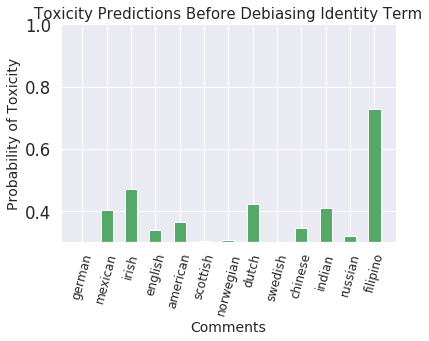

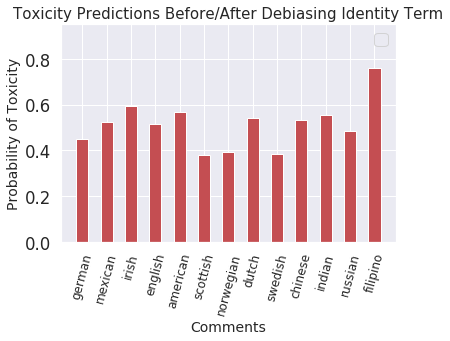

In [235]:
%matplotlib inline
s=[]
for i in nationalities:
    if i.lower() not in ["italian","french","polish"]:
        s.append("i am " +i.lower())
p=[]
d=[]
for i in s:
    n=2
    a =i.split(" ")
    p.append(model.predict_proba([np.mean(_np_normalize(embeddings[a]),axis=0)])[0][0])
    de = _np_normalize(embeddings[a])
    de[n,:] = _np_normalize(embeddings[a[n]])-(np.dot(np.dot(w_h[5],w_h[5].T),_np_normalize(embeddings[a[n]])))
    d.append((model.predict_proba([np.mean(de,axis=0)])[0][0]))

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,p,width=.5,color='g',label="debias delta")
plt.xticks(index, s, fontsize=12, rotation=75)
plt.ylim(top=1,bottom=.3)

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before/After Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,d,width=.5,color='r')
plt.xticks(index, s, fontsize=12, rotation=75)
plt.legend(loc='upper middle')
plt.ylim(top=.95,bottom=0)

(0, 1)

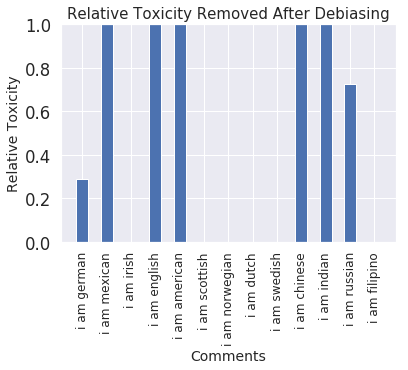

In [232]:
plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Relative Toxicity', fontsize=14)
plt.title("Relative Toxicity Removed After Debiasing",fontsize= 15)
index = np.arange(13)
delta = np.abs(p)-np.abs(d)
plt.bar(index,np.array(delta)/(np.array(p)-.5),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)

# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, s, fontsize=12, rotation=90)
plt.ylim(top=1,bottom=0)

(0, 1)

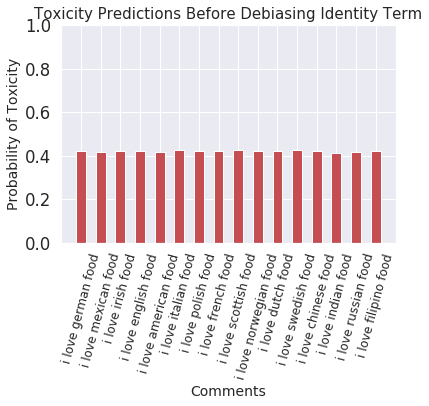

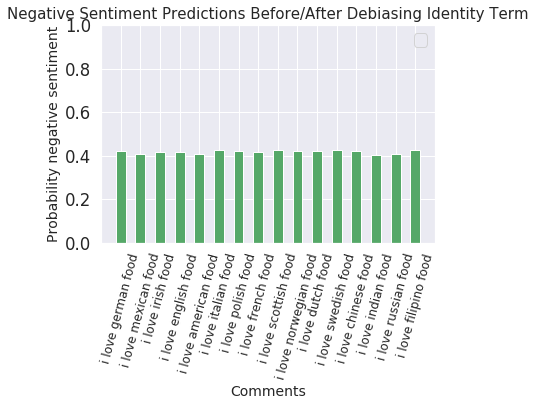

In [238]:
s=[]
for i in nationalities:
    s.append("i love " + i.lower() + " food")
p=[]
d=[]
for i in s:
    n=2
    a =i.split(" ")
    p.append(clf.predict_proba([np.mean(_np_normalize(embeddings[a]),axis=0)])[0][0])
    de = _np_normalize(embeddings[a])
    de[n,:] = _np_normalize(embeddings[a[n]])-(np.dot(np.dot(w_h[4],w_h[4].T),_np_normalize(embeddings[a[n]])))
    d.append((clf.predict_proba([np.mean(de,axis=0)])[0][0]))

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,p,width=.5,color='r',label="debias delta")
plt.xticks(index, s, fontsize=12, rotation=75)
plt.ylim(top=1,bottom=0)

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability negative sentiment', fontsize=14)
plt.title("Negative Sentiment Predictions Before/After Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,d,width=.5,color='g')
plt.xticks(index, s, fontsize=12, rotation=75)
plt.legend(loc='upper right')
plt.ylim(top=1,bottom=0)

## Evaluate Word Embeddings before and after debiasing

In [50]:
table = {}
table1 = {}
for i in analogies:
    for j in i:
        if not j in table:
            table[j.lower()] = 1
            table1[j.lower()] = [i]
        else: 
            table1[j.lower()].append(i)
            table[j.lower()]+=1

In [51]:
for i in nationalities:
    if i.lower() in table1:
        print table1[i.lower()],i

[['Ukraine', 'Ukrainian', 'Germany', 'German']] German
[['Ukraine', 'Ukrainian', 'Mexico', 'Mexican']] Mexican
[['Ukraine', 'Ukrainian', 'Ireland', 'Irish']] Irish
[['Ukraine', 'Ukrainian', 'England', 'English']] English
[['Ukraine', 'Ukrainian', 'Italy', 'Italian']] Italian
[['Ukraine', 'Ukrainian', 'Poland', 'Polish']] Polish
[['Ukraine', 'Ukrainian', 'France', 'French']] French
[['Ukraine', 'Ukrainian', 'Norway', 'Norwegian']] Norwegian
[['Ukraine', 'Ukrainian', 'Netherlands', 'Dutch']] Dutch
[['Ukraine', 'Ukrainian', 'Sweden', 'Swedish']] Swedish
[['Ukraine', 'Ukrainian', 'China', 'Chinese']] Chinese
[['Ukraine', 'Ukrainian', 'India', 'Indian']] Indian
[['Ukraine', 'Ukrainian', 'Russia', 'Russian']] Russian


In [52]:
for i in nationalities:
    if i.lower() in table:
        print table[i.lower()],i

1 German
1 Mexican
1 Irish
1 English
1 Italian
1 Polish
1 French
1 Norwegian
1 Dutch
1 Swedish
1 Chinese
1 Indian
1 Russian


In [179]:
w_h = w_h[6:]

In [309]:
w=None
with sess.as_default():
    
#     w= trained_model.projection.eval()
    w= w_h[6]

In [310]:
client.similar_by_vector(_np_normalize(embeddings['amazing']))

[(u'amazing', 0.9999999403953552),
 (u'incredible', 0.9194009900093079),
 (u'fantastic', 0.8431944847106934),
 (u'wonderful', 0.8312845826148987),
 (u'astonishing', 0.8230013847351074),
 (u'marvelous', 0.8176810145378113),
 (u'awesome', 0.8062849044799805),
 (u'unbelievable', 0.8006238341331482),
 (u'remarkable', 0.7889994382858276),
 (u'terrific', 0.7745215892791748)]

In [311]:
client.similar_by_vector(_np_normalize(embeddings['american']))

[(u'american', 1.0),
 (u'u.s.', 0.7868137359619141),
 (u'british', 0.7301285862922668),
 (u'america', 0.7278162240982056),
 (u'americans', 0.725959300994873),
 (u'us', 0.7098501324653625),
 (u'states', 0.6988692879676819),
 (u'canadian', 0.6986786723136902),
 (u'united', 0.6888286471366882),
 (u'world', 0.6818901300430298)]

In [312]:
client.similar_by_vector(_np_normalize(embeddings['american'])-np.dot(np.dot(w,w.T),_np_normalize(embeddings['american'])))

[(u'american', 0.8284979462623596),
 (u'u.s.', 0.6342868804931641),
 (u'canadian', 0.5838972926139832),
 (u'british', 0.571607232093811),
 (u'americans', 0.5519481897354126),
 (u'u.s', 0.5251040458679199),
 (u'us', 0.5121021270751953),
 (u'french', 0.5050187706947327),
 (u'hispanic', 0.5003875494003296),
 (u'cuban', 0.49751409888267517)]

In [313]:
words= filter(lambda x: x.lower() in embeddings,nationalities)

0.888852715492


<Figure size 432x288 with 0 Axes>

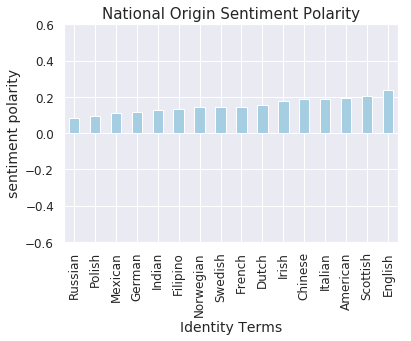

In [314]:
with sess.as_default():

    df1 = pd.DataFrame(data={"Identity Terms": list(words)})
    df1["sentiment polarity"] = df1["Identity Terms"].map(
        lambda a: (_np_normalize(embeddings[a.lower()]).dot(vec)))
    df1.sort_values(by="sentiment polarity", inplace=True)
    plt.figure()
    df1.plot.bar(legend = False, ylim= (-.6,.6),x="Identity Terms",y="sentiment polarity",title= "Debiased Religion Sentiment Polarity",fontsize=12, colormap='Paired')
    plt.xlabel('Identity Terms', fontsize=14)
    plt.ylabel('sentiment polarity', fontsize=14)
    plt.title("National Origin Sentiment Polarity",fontsize= 15)
a=map(lambda a: (embeddings[a.lower()]).dot(vec),words)
print np.sum(np.array(a)**2)/len(a)

In [315]:
words= df1["Identity Terms"].values

0.19675514102


<Figure size 432x288 with 0 Axes>

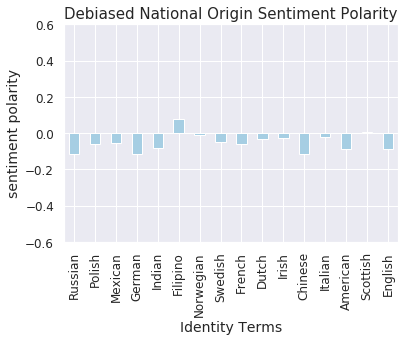

In [316]:
# w= w_h[0][4]
with sess.as_default():

    df = pd.DataFrame(data={"Identity Terms": list(words)})
    df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec))
#     df.sort_values(by="sentiment polarity", inplace=True)
    plt.figure()
    df.plot.bar(legend = False, ylim= (-.6,.6),x="Identity Terms",y="sentiment polarity",title= "Debiased Religion Sentiment Polarity",fontsize=12, colormap='Paired')
    plt.xlabel('Identity Terms', fontsize=14)
    plt.ylabel('sentiment polarity', fontsize=14)
    plt.title("Debiased National Origin Sentiment Polarity",fontsize= 15)
a=map(lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec),words)
print np.sum(np.array(a)**2)/len(a)

(-0.6, 0.6)

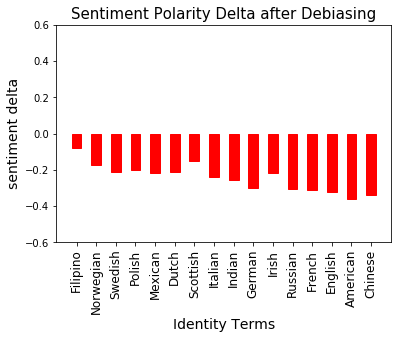

In [207]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('sentiment delta', fontsize=14)
plt.title("Sentiment Polarity Delta after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = df["sentiment polarity"].values-df1["sentiment polarity"].values
bar = plt.bar(index,delta,width=.5)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=.6,bottom=-.6)

(-1, 1)

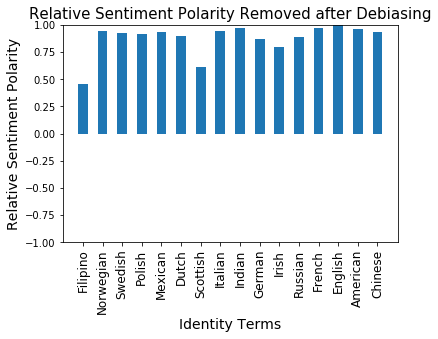

In [208]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('Relative Sentiment Polarity', fontsize=14)
plt.title("Relative Sentiment Polarity Removed after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = np.abs(df1["sentiment polarity"].values)-np.abs(df["sentiment polarity"].values)
plt.bar(index,delta/np.abs(df1["sentiment polarity"].values),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)
# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=1,bottom=-1)

## evaluate gender toxicity/negative sentiment distributions

In [209]:
import seaborn
# name_occurence.sort_values(ascending=True,by="toxicity")
male = ["male","him","man","boy","his","father","dad","men"]
female= ["female","her","woman","girl","hers","mother","mom","women"]

<IPython.core.display.Javascript object>


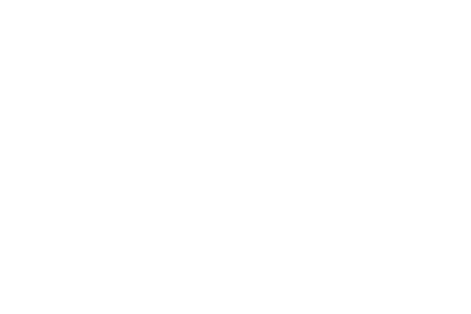

(-0.15, 0.2)

<IPython.core.display.Javascript object>


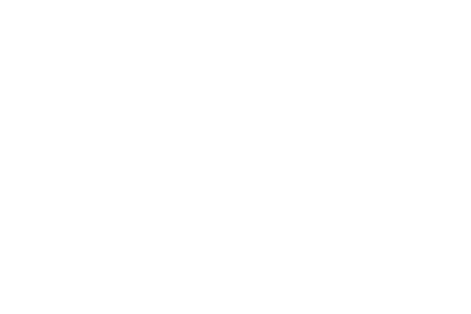

In [210]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.15, .2])


<IPython.core.display.Javascript object>


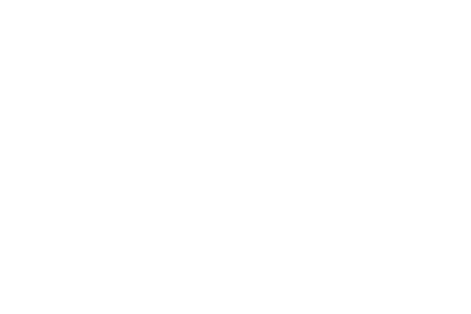

(-0.2, 0.1)

<IPython.core.display.Javascript object>


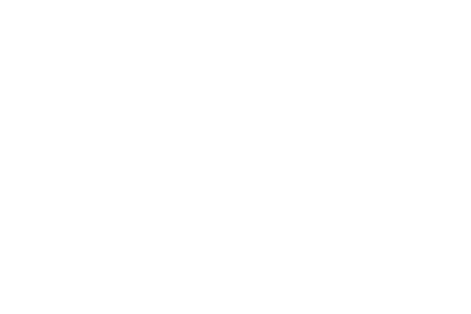

In [211]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.2, .1])

0.20355020222002063
0.2775666800500944


<IPython.core.display.Javascript object>


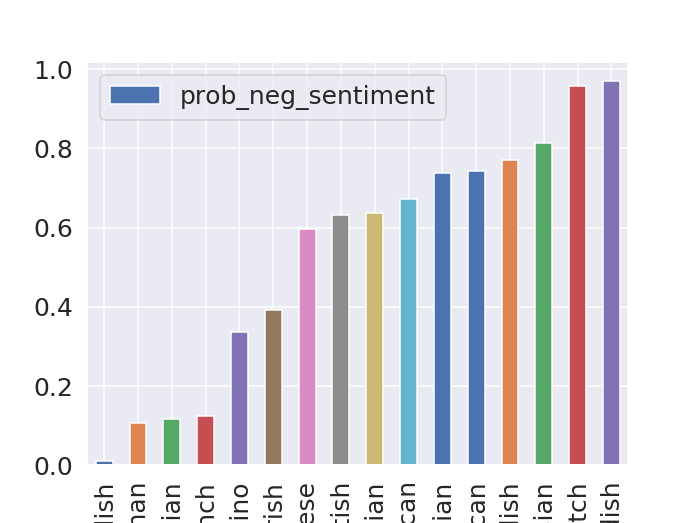

In [74]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda w: clf.predict_proba([embeddings[w.lower()]])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)
df.plot.bar(x="word",y="prob_neg_sentiment")


0.20318198136483467
0.27726869360041706


<IPython.core.display.Javascript object>


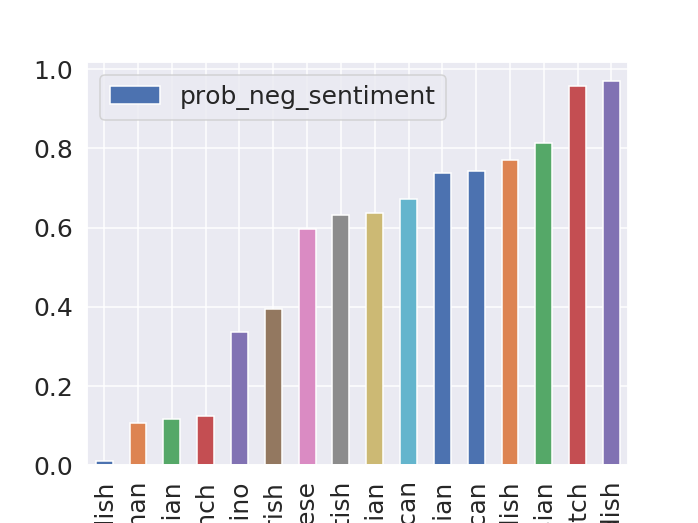

In [75]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda a: clf.predict_proba([(embeddings[a.lower()]-np.dot(np.dot(w,w.T),embeddings[a.lower()]))])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)

df.plot.bar(x="word",y="prob_neg_sentiment")

## test wordsim accruacy on debiased word embeddings

In [69]:
evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)

((0.6238773451304681, 1.7963247628700625e-39),
 SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
 0.0)

## test analogy accruacy on debiased word embeddings

In [70]:
(X,y,l) = load_vectors_test(embeddings,analogies)
analogy_accuracy(X,l,embeddings,n = 1,samples=100,model=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


0.21